In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
from scipy import stats

### 데이터 읽어오기

In [162]:
df = pd.read_excel("dataset_added.xlsx")

# 1. 수면 종합점수 sleep_score와 연관성이 가장 높은 항목 두 개를 추출하고, sleep_score를 설명하는 중요한 요인을 파악.

## 결과:
    sleep_score를 가장 잘 설명하는 두 개의 요인: 
        * sleep_total
        * sleep_efficiency

In [163]:
#sleep 관련 변수 필터링
sleep_cols = [col for col in df.columns if 'sleep_' in col.lower()]
sleep_data = df[sleep_cols]

In [164]:
#sleep 관련 각각 col들과 'sleep_score'와의 pearson correlation 구하기
tmp_sleep_data = sleep_data.drop('sleep_score_total', axis = 1, inplace = False)
corr_score_for_each_var = tmp_sleep_data.corr(method='pearson', numeric_only=True)['sleep_score']

#pearson correlation이 가장 높은 두 개의 col 구하기
top2_highest_corr = corr_score_for_each_var.drop('sleep_score').abs().nlargest(2)
var1 = top2_highest_corr.index[0]
var2 = top2_highest_corr.index[1]

#방금 구한 두 개의 col과 sleep_score와의 pearson correlation의 신뢰성 검정하기
data_clean = df.dropna(axis=0, how='any', inplace=False)

for x in top2_highest_corr.index:
    var, pvalue_var = pearsonr(data_clean[x], data_clean['sleep_score'])
    print(f'{x}의 pearson correlation은 {round(var, 4)}이고, p-value는 {round(pvalue_var, 4)}입니다.')
    if (pvalue_var < 0.05):
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있습니다.')
    else:
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있다고 볼 수 없습니다.')
    print('\n')

sleep_total의 pearson correlation은 0.7534이고, p-value는 0.0입니다.
sleep_total은 sleep_score와 유의미하게 상관성이 있습니다.


sleep_efficiency의 pearson correlation은 0.6219이고, p-value는 0.0입니다.
sleep_efficiency은 sleep_score와 유의미하게 상관성이 있습니다.




### 1.2 sleep_cols들과 sleep_score의 상관성을 시각화: png로 저장

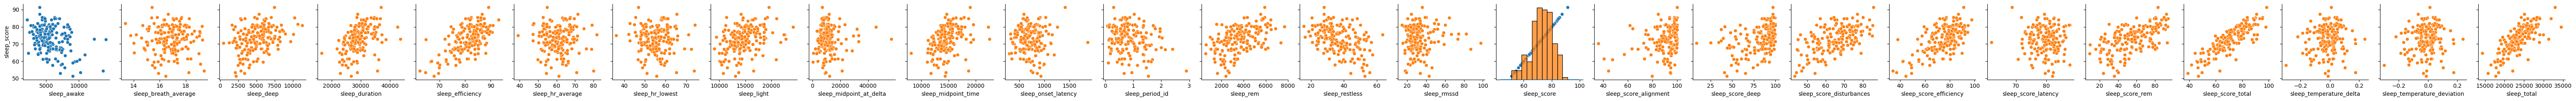

In [165]:
#sleep_cols들과 sleep_score의 상관성을 scatter plot으로 그린 결과
g = sns.pairplot(data=sleep_data, x_vars= sleep_cols, y_vars= ['sleep_score'], kind='scatter',diag_kind='kde', dropna=True)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

plt.savefig('sleep_cols_and_sleep_score.png')

# 2. ANOVA: CN, MCI, Dem 그룹의 sleep_score가 차이나는 지 검사
* H0: CN, MCI, Dem의 평균 수면 점수는 서로 동일하다 (치매 단계 간 수면 점수의 평균에 차이가 없다.)
* H1: CN, MCI, Dem 세 그룹 중 적어도 하나의 그룹의 수면 점수가 다른 그룹과 차이가 있다.
* alpha = 0.05

## 분석 결과:
    각 진단명 CN, MCI, Dem에서 sleep_score에 유의미한 차이가 없다.

### ANOVA TABLE

In [166]:
sleep_score_fit = smf.ols("sleep_score~C(DIAG_NM, Sum)", data = df).fit()
table = sm.stats.anova_lm(sleep_score_fit)
print(table)

alpha = 0.05
p_value = table['PR(>F)'].iloc[0]
if (p_value > alpha):
    print("\nH0를 기각하지 않습니다.\n수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.")
else:
    print("\nH0를 기각합니다.\n수면시간은 각 진단명에 따라 차이가 있습니다.")

                    df       sum_sq    mean_sq       F    PR(>F)
C(DIAG_NM, Sum)    2.0    36.865094  18.432547  0.3169  0.728831
Residual         171.0  9946.256147  58.165241     NaN       NaN

H0를 기각하지 않습니다.
수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.


### Mulicomparison table

In [167]:
comp = mc.MultiComparison(df['sleep_score'], df['DIAG_NM'])
compatible,_,_ = comp.allpairtest(stats.ttest_ind, method = 'bonf')
compatible

group1,group2,stat,pval,pval_corr,reject
CN,Dem,0.4222,0.6736,1.0,False
CN,MCI,0.743,0.4586,1.0,False
Dem,MCI,-0.025,0.9801,1.0,False


# 5. Binary Logistic regression : between sleep factors and CN / non-CN

## 결과:

### 데이터 전처리
* sleep 관련 속성들과 DIAG_NM의 속성을 CN: 0, non-CN: 1로 치환하여 dataframe 생성

In [168]:
from imblearn.over_sampling import SMOTE
from collections import Counter

data = pd.read_excel("dataset_added.xlsx")

#sleep 관련 변수 필터링
sleep_cols = [col for col in data.columns if 'sleep_' in col.lower()]
sleep_data = data[sleep_cols]

x_bin = sleep_data

mapping = {'CN': 0, 'MCI': 1, 'Dem': 1}
data['DIAG_NM_numeric'] = data['DIAG_NM'].map(mapping)
y_bin = data['DIAG_NM_numeric']

# 오버샘플링 수행
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_bin, y_bin)

# # NumPy 배열로 반환된 결과를 DataFrame으로 변환 (X_train이 DataFrame일 때)
# if isinstance(x_bin, pd.DataFrame):
#     X_res = pd.DataFrame(x_res, columns=x_bin.columns)
#     Y_res = pd.Series(y_res, name=y_bin.name)

# 클래스 비율 확인
print("Resampled class distribution with SMOTE:", Counter(y_res))

# Resampled 데이터를 DataFrame으로 변환
smote_df = pd.DataFrame(x_res, columns=x_bin.columns)
smote_df['DIAG_NM_numeric'] = y_res

print(smote_df.head())  # SMOTE로 생성된 데이터 확인

#new_df_bin = pd.concat([x_bin, y_bin], axis=1)


Resampled class distribution with SMOTE: Counter({1: 111, 0: 111})
   sleep_awake  sleep_breath_average  sleep_deep  sleep_duration  \
0   7162.85714              16.45437  4302.85714     30706.66667   
1   2055.66372              16.30752  6152.12389     30115.75221   
2   7252.24138              16.89224  3081.72414     27499.65517   
3   3436.47541              17.29201  7519.18033     26599.67213   
4   6641.91176              14.86949  4346.91176     28521.17647   

   sleep_efficiency  sleep_hr_average  sleep_hr_lowest  sleep_light  \
0          77.12698          57.95794         52.15873  15489.04762   
1          93.07080          65.23195         57.83186  16303.53982   
2          74.06897          53.17534         46.98276  12873.10345   
3          87.24590          51.67164         47.95082  13198.52459   
4          77.76471          63.37368         56.72059  14918.38235   

   sleep_midpoint_at_delta  sleep_midpoint_time  ...  sleep_score_deep  \
0              14927.74

### test-set, train-set 분리

In [169]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(smote_df.iloc[:,:-1], 
                                                    smote_df.iloc[:,-1], 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    stratify=smote_df['DIAG_NM_numeric'])

print("The dimension of the trainset is ", x_train.shape)
print("The dimension of the testset is ", x_test.shape)
print(y_train.value_counts(normalize=True))

The dimension of the trainset is  (155, 26)
The dimension of the testset is  (67, 26)
DIAG_NM_numeric
0    0.503226
1    0.496774
Name: proportion, dtype: float64


In [170]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(x_train)
xtest_scaled = scaler.fit_transform(x_test)

### Training with Logistic regression

In [171]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(tol=1e-08).fit(xtrain_scaled, y_train)
coef = {}
i = 0
for col in x_bin.columns:
    coef.setdefault(col,model1.coef_[0][i])
    i += 1
print("_____________________________________________")
print("regression coefficients are ", coef)
print("inpercept is ", model1.intercept_)
print("model score is ", model1.score(xtrain_scaled, y_train))
print("_____________________________________________")

_____________________________________________
regression coefficients are  {'sleep_awake': np.float64(0.1964839938094168), 'sleep_breath_average': np.float64(0.107933570967207), 'sleep_deep': np.float64(-0.2671074135542251), 'sleep_duration': np.float64(0.37892932612484975), 'sleep_efficiency': np.float64(-0.06634471785497344), 'sleep_hr_average': np.float64(-0.02982154040799411), 'sleep_hr_lowest': np.float64(-0.2694204545638961), 'sleep_light': np.float64(0.5066611956620449), 'sleep_midpoint_at_delta': np.float64(-0.10803705627980946), 'sleep_midpoint_time': np.float64(-0.2761236433242865), 'sleep_onset_latency': np.float64(-0.2849211004848742), 'sleep_period_id': np.float64(-0.009487356911165873), 'sleep_rem': np.float64(0.153252231023085), 'sleep_restless': np.float64(0.15772097062665252), 'sleep_rmssd': np.float64(-0.13832850444323722), 'sleep_score': np.float64(-0.1986661942213023), 'sleep_score_alignment': np.float64(0.46323656056093), 'sleep_score_deep': np.float64(-0.049592306

In [172]:
y_pred = model1.predict(xtest_scaled)
print("predicted DIAG_NMs are ", y_pred)

predicted DIAG_NMs are  [0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0
 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1]


[[23 10]
 [10 24]]


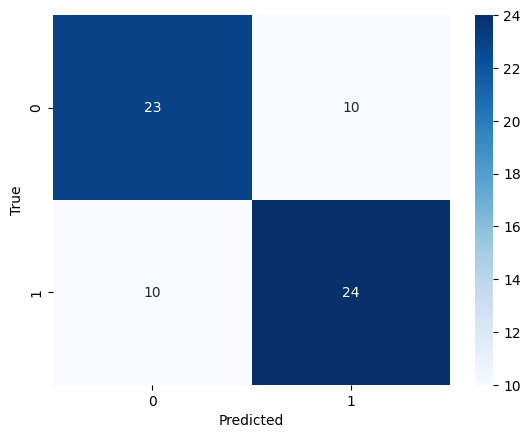

In [173]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [174]:
print(metrics.classification_report(y_test, y_pred, target_names=['CN', 'non-CN']))

              precision    recall  f1-score   support

          CN       0.70      0.70      0.70        33
      non-CN       0.71      0.71      0.71        34

    accuracy                           0.70        67
   macro avg       0.70      0.70      0.70        67
weighted avg       0.70      0.70      0.70        67

